# Data exploration of the CFIS-W3 lensing catalog

In this notebook, we are using the non-public data of the **full CFIS-W3 field** (50 deg^2) provided elsewhere.

In [1]:
%pylab inline
%config Completer.use_jedi = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

## 1st session
07/10/2021

Look at some basic quantities in catalogue (positions, flags, magnitude, ...)

In [3]:
# Load catalogue (numpy file)
dd = np.load('./catalogue_CFIS_W3/final_cat.npy')

**SExtractor denominations:**

- XWIN_WORLD: RA
- YWIN_WORLD: DEC

Shape measurement is done with two methods
- ngmix (preferred): model fitting (mixture of gaussians) on multi-epoch images, easy to process metacalibration with it
- galsim (depreciated): quadrupole moment measurements on stacks, shear estimate looks very biases probably due to inaccurate stacked PSF model

In [4]:
# Show column names
print(dd.dtype.names)

('XWIN_WORLD', 'YWIN_WORLD', 'TILE_ID', 'FLAGS', 'IMAFLAGS_ISO', 'NGMIX_MCAL_FLAGS', 'NGMIX_ELL_PSFo_NOSHEAR', 'GALSIM_PSF_ELL_ORIGINAL_PSF', 'SPREAD_CLASS', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'N_EPOCH', 'NGMIX_N_EPOCH', 'NGMIX_ELL_1M', 'NGMIX_ELL_1P', 'NGMIX_ELL_2M', 'NGMIX_ELL_2P', 'NGMIX_ELL_NOSHEAR', 'NGMIX_ELL_ERR_NOSHEAR', 'NGMIX_FLAGS_1M', 'NGMIX_FLAGS_1P', 'NGMIX_FLAGS_2M', 'NGMIX_FLAGS_2P', 'NGMIX_FLAGS_NOSHEAR', 'NGMIX_T_1M', 'NGMIX_T_1P', 'NGMIX_T_2M', 'NGMIX_T_2P', 'NGMIX_T_NOSHEAR', 'NGMIX_T_ERR_1M', 'NGMIX_T_ERR_1P', 'NGMIX_T_ERR_2M', 'NGMIX_T_ERR_2P', 'NGMIX_T_ERR_NOSHEAR', 'NGMIX_Tpsf_1M', 'NGMIX_Tpsf_1P', 'NGMIX_Tpsf_2M', 'NGMIX_Tpsf_2P', 'NGMIX_Tpsf_NOSHEAR', 'NGMIX_FLUX_1M', 'NGMIX_FLUX_1P', 'NGMIX_FLUX_2M', 'NGMIX_FLUX_2P', 'NGMIX_FLUX_NOSHEAR', 'NGMIX_FLUX_ERR_1M', 'NGMIX_FLUX_ERR_1P', 'NGMIX_FLUX_ERR_2M', 'NGMIX_FLUX_ERR_2P', 'NGMIX_FLUX_ERR_NOSHEAR', 'GALSIM_GAL_ELL_1M', 'GALSIM_GAL_ELL_1P', 'GALSIM_GAL_ELL_2M', 'GALSIM_GAL_ELL_2P', 'GALSIM_GAL_ELL_NOSHEAR', 'GAL

How many objects do we have?

In [5]:
len(dd)

5367032

Map the distribution of objects on the sky

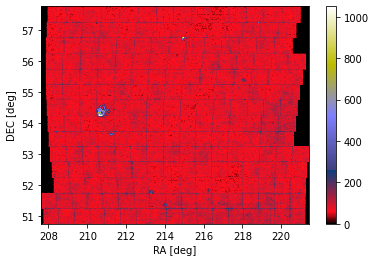

In [6]:
hist2d(dd['XWIN_WORLD'], dd['YWIN_WORLD'], 256, cmap='gist_stern');
xlabel('RA [deg]')
ylabel('DEC [deg]')
_ = colorbar()

Apply some masking to the catalog

In [7]:
# FLAG_TILING = 0: duplicate objects due to overlapping tiles
# FLAGS != 0: SExtractor mask
# IMAFLAGS_ISO != 0: masked objects (bright stars, Messier objects, chip defects, ...)
# NGMIX_ELL_NOSHEAR = -10: invalid measurement (e.g. invalid PSF)
# NGMIX_FLAGS_NOSHEAR != 1: failed shape measurement

# mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS']==0) \
#   & (dd['IMAFLAGS_ISO'] == 0) \
#   & (dd['NGMIX_ELL_NOSHEAR'][:,0] > -10) \
#   & (dd['NGMIX_FLAGS_NOSHEAR'] != 1)[0]


# Trying out this mask
mask = (dd['FLAG_TILING'] == 1) & (dd['FLAGS'] == 0) & (dd['IMAFLAGS_ISO'] == 0) & \
        (dd['NGMIX_FLAGS_NOSHEAR'] == 0) &  (dd['NGMIX_MCAL_FLAGS'] == 0)

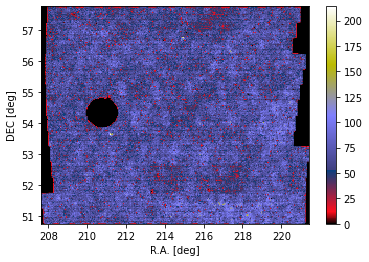

In [8]:
hist2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 256, cmap='gist_stern');
xlabel('R.A. [deg]')
ylabel('DEC [deg]')
_ = colorbar()

r band magnitude distribution

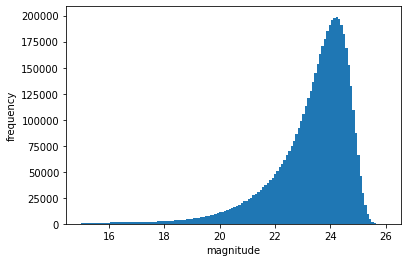

In [9]:
hist(dd['MAG_AUTO'], range=(15,26), bins=128);
_ = xlabel('magnitude')
_ = ylabel('frequency')

r band SNR distribution

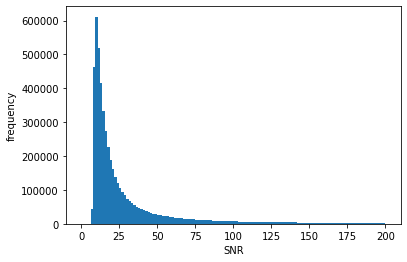

In [10]:
hist(dd['SNR_WIN'], range=(0,200), bins=128);
_ = xlabel('SNR')
_ = ylabel('frequency')

Mean ellipticity

In [11]:
print(dd['NGMIX_ELL_NOSHEAR'].shape)
print('mean e1', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][mask]))
print('mean e2', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][mask]))

(5367032, 2)
mean e1 -0.0005714872916208202
mean e2 0.0004328348554080995


## 2nd session
14/10/2021

Explore in more detail galaxy selection.

Load star catalogue.

SPREAD_CLASS classification

(Depreciated, we will use SPREAD_MODEL later.)

Note that only galaxies will be selected on the stacks. Stars have been detected on the single exposures, this provides a more homogeneous star sample. We will look at the (validation) star catalogue later.

0: stars
1: galaxies
2: artefacts

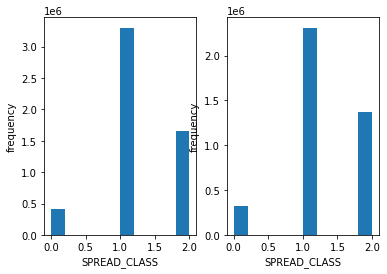

In [12]:
# Plot distribution
subplot(121)
_ = hist(dd['SPREAD_CLASS'])
_ = xlabel('SPREAD_CLASS')
_ = ylabel('frequency')

subplot(122)
_ = hist(dd['SPREAD_CLASS'][mask])
_ = xlabel('SPREAD_CLASS')
_ = ylabel('frequency')

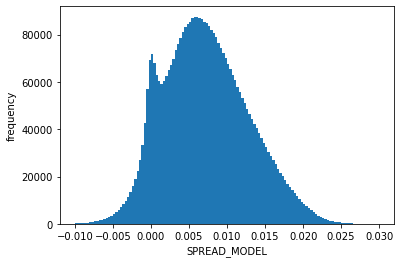

In [13]:
# Preferred classification: SPREAD_MODEL
# See SExtractor documentation https://sextractor.readthedocs.io/en/latest/Model.html#model-based-star-galaxy-separation-spread-model
# Here, this flag is computed by the ShapePipe implementation of the spread model

# Plot distribution
_ = hist(dd['SPREAD_MODEL'][mask], range=[-0.01, 0.03], bins=128)
_ = xlabel('SPREAD_MODEL')
_ = ylabel('frequency')

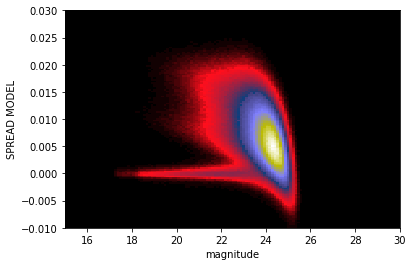

In [14]:
# Typically, one plots the 2D distribution of magnitude and spread model, to identify the *stellar locus*, i.e.
# a number of objects with more or less the same size

_ = hist2d(dd['MAG_AUTO'][mask], dd['SPREAD_MODEL'][mask], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')

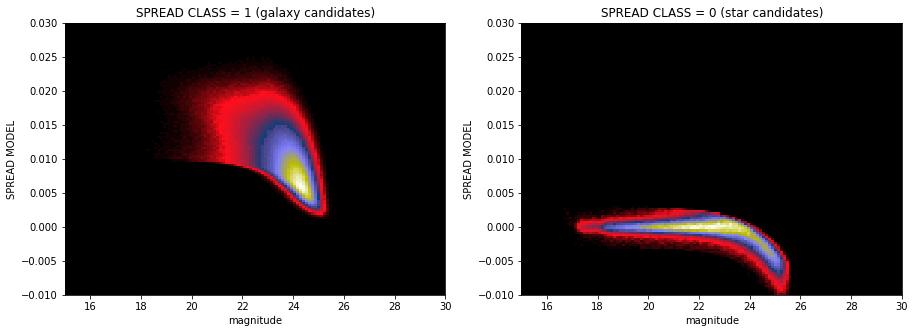

In [15]:
# See whether we can better see the galaxy and star distribution when splitting the data
# according to SPREAD_CLASS

mask_galaxies = mask & (dd['SPREAD_CLASS']==1)

figure(figsize=[15,5])
subplot(121)
_ = hist2d(dd['MAG_AUTO'][mask_galaxies], dd['SPREAD_MODEL'][mask_galaxies], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 1 (galaxy candidates)')

mask_stars = mask & (dd['SPREAD_CLASS']==0)

subplot(122)
_ = hist2d(dd['MAG_AUTO'][mask_stars], dd['SPREAD_MODEL'][mask_stars], range=[[15, 30], [-0.01, 0.03]],
           bins=128, cmap='gist_stern')
_ = xlabel('magnitude')
_ = ylabel('SPREAD MODEL')
_ = title('SPREAD CLASS = 0 (star candidates)')

### Look at (validation) star catalog
The PSF model was created using stars detected and selected on single-exposure images. In fact, a random sub-set of 80% of all stars was used to create the PSF model, 20% are kept as vaidation set, which we willl look at here.

The validation stars are stored in a separate file, which is the union of all single-exposure selected validation stars.

#### Two methods to load fits table

In [16]:
from astropy.io import fits
star_path = './catalogue_CFIS_W3/output/run_sp_MsPl/mccd_merge_starcat_runner/output/full_starcat-0000000.fits'

In [17]:
stars_cat = fits.getdata(star_path)

In [18]:
from astropy.table import Table

In [19]:
stars_cat = Table.read(star_path, hdu=2)

In [20]:
stars_cat

X,Y,RA,DEC,E1_PSF_HSM,E2_PSF_HSM,SIGMA_PSF_HSM,E1_STAR_HSM,E2_STAR_HSM,SIGMA_STAR_HSM,FLAG_PSF_HSM,FLAG_STAR_HSM,CCD_NB
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5655.071395124369,5279.214739098517,217.82663582087287,54.77844259649623,0.06664546013000466,-0.049135098381858304,1.5797637701034546,0.060129399125684754,-0.034367393753435414,1.5556344985961914,0.0,0.0,0.0
-5343.009734439577,5704.926691200415,217.7987110599747,54.80043341126079,0.05792693309369971,-0.04129280830916392,1.5584254264831543,0.08364215624866449,-0.037897859360399966,1.5426160097122192,0.0,0.0,0.0
-5678.412263601143,9409.454217525388,217.82782104440528,54.99042946287721,0.04776511477621796,-0.0836767702194216,1.6429502964019775,0.003825565889885061,-0.05474192806394717,1.59054434299469,0.0,0.0,0.0
-6025.913945265132,7109.661388612281,217.8593681367769,54.87222335981904,0.058715833563876,-0.04180727255062146,1.5368461608886719,0.0748434025323804,-0.05335470965185339,1.5682880878448486,0.0,0.0,0.0
-5496.535703385833,7689.441284959215,217.81193326280484,54.902227985021945,0.06050961556375801,-0.0506556021889481,1.5530987977981567,0.048600848111630075,-0.02515582568472467,1.5489903688430786,0.0,0.0,0.0
-5667.527799305658,5639.927007733217,217.8276678998636,54.79695198096755,0.06186273096054109,-0.04461564301400481,1.564837098121643,0.06751784269856966,-0.03727211997310413,1.519326090812683,0.0,0.0,0.0
-4862.05607217563,7799.660170079584,217.75516888878155,54.90815543920137,0.06587982079167724,-0.053426953095139645,1.5588291883468628,0.05576049660420453,-0.04439083898283978,1.5419180393218994,0.0,0.0,0.0
-4860.3028857939435,6688.294107323913,217.7553559760284,54.85111160455157,0.054721920209811314,-0.036955862472197606,1.5364415645599365,0.060815959990342984,-0.03994012522109251,1.5554977655410767,0.0,0.0,1.0
-5846.117157971118,8876.389931656708,217.8429543299225,54.96299104565496,0.03561304503848562,-0.059874500100288754,1.5912493467330933,0.04172981776170023,-0.042188382093558664,1.5612646341323853,0.0,0.0,1.0


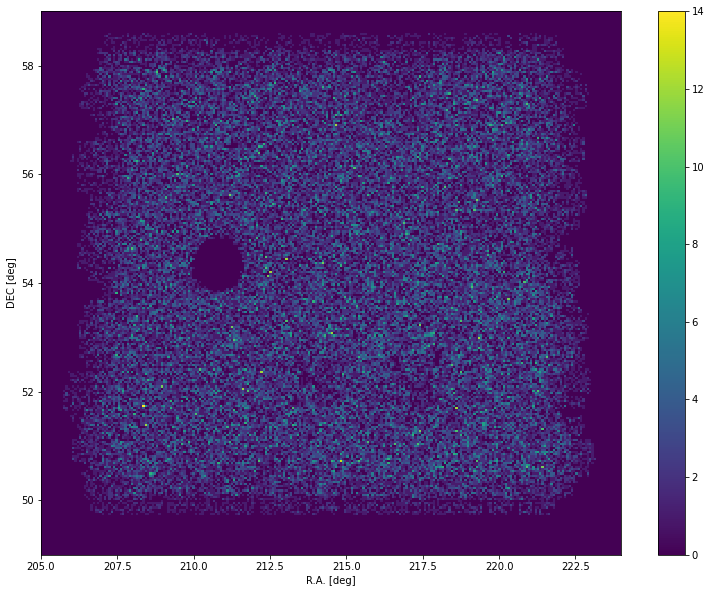

In [21]:
# Plot spatial distribution
# Patterns can be seen that reflect the survey strategy of using large dithers. A given star appears on
# typically three exposures with varying PSF, since the position in the focal plane as well as the
# observing conditions change. The number of exposures also varies. In particular at the borders of the field
# we can see this decreased depth, and also the geometry of the MegaCAM CCD mosaic with the 4 new "ear" CCDs.

figure(figsize=(13,10))
hist2d(stars_cat['RA'], stars_cat['DEC'], range=[[205, 224], [49, 59]], bins=256);
_ = colorbar()
_ = xlabel('R.A. [deg]')
_ = ylabel('DEC [deg]')

## 3rd session
21/10/2021

Calculate the response matrix R for galaxies and stars

In [22]:
# Refine the mask from the last sessions, to correctly select the galaxies

# Rule: sm_classif > 0.0035
sm_classif = dd['SPREAD_MODEL'] + 2 * dd['SPREADERR_MODEL']
selected_gals = sm_classif > 0.0035


# The size of the galaxy measured by ngmix is the size of the galaxy after the deconvolution
# by the PSF. Mask proposed by Axel.
size_mask = (dd['NGMIX_T_NOSHEAR'] / dd['NGMIX_Tpsf_NOSHEAR']) > 0.5

mask_spread_mod = mask & (selected_gals) & (dd['SPREAD_MODEL'] > 0) & (size_mask)

/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [23]:
### Response matrix for galaxies

Mean(R11) =  0.6186325650470758
Mean(R12) =  -0.00038264528300505676
Mean(R21) =  -4.624142891512218e-05
Mean(R22) =  0.6122851915964442


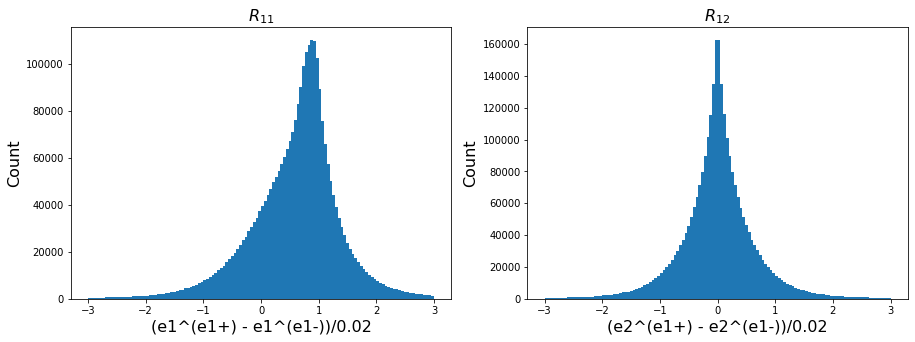

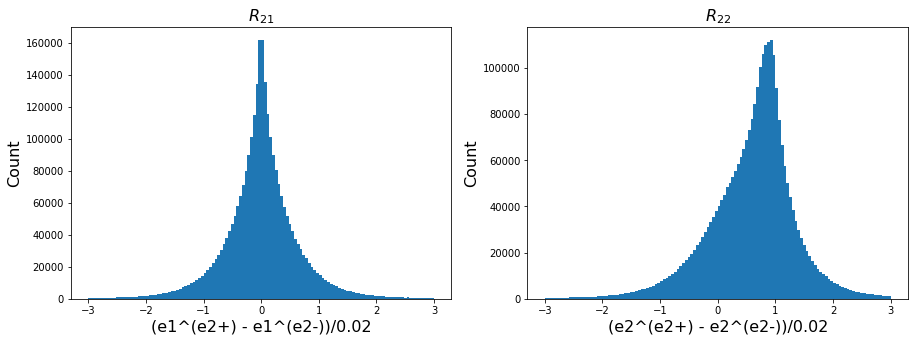

In [24]:
# Response matrix:
# Rij = del[ellipticity_i] / del[shear_j]
#     = change of observed elipticity component #i with respect to shear component #j

# Compute all four matrix elements with finite differences.
# Added shear:
dg = 0.01
R11 = (dd['NGMIX_ELL_1P'][mask_spread_mod][:,0] - dd['NGMIX_ELL_1M'][mask_spread_mod][:,0]) / (2 * dg)
R12 = (dd['NGMIX_ELL_1P'][mask_spread_mod][:,1] - dd['NGMIX_ELL_1M'][mask_spread_mod][:,1]) / (2 * dg)

R22 = (dd['NGMIX_ELL_2P'][mask_spread_mod][:,1] - dd['NGMIX_ELL_2M'][mask_spread_mod][:,1]) / (2 * dg)
R21 = (dd['NGMIX_ELL_2P'][mask_spread_mod][:,0] - dd['NGMIX_ELL_2M'][mask_spread_mod][:,0]) / (2 * dg)

range = [-3, 3]
nbins = 126
size = 16

fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R11, bins=nbins, range=range)
_ = xlabel(f'(e1^(e1+) - e1^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$', size=size)

subplot(122)
_ = hist(R12, bins=nbins, range=range)
_ = xlabel(f'(e2^(e1+) - e2^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{12}$', size=size)


fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R21, bins=nbins, range=range)
_ = xlabel(f'(e1^(e2+) - e1^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$', size=size)


subplot(122)
_ = hist(R22, bins=nbins, range=range)
_ = xlabel(f'(e2^(e2+) - e2^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{22}$', size=size)


print('Mean(R11) = ', np.mean(R11))
print('Mean(R12) = ', np.mean(R12))
print('Mean(R21) = ', np.mean(R21))
print('Mean(R22) = ', np.mean(R22))

### Response matrix for stars

In [25]:
# Create mask to select stars

mask_stars = mask & (dd['SPREAD_CLASS']==0)

Mean(R11_stars) =  0.17426761654817355
Mean(R12_stars) =  0.0008290025792978885
Mean(R21_stars) =  0.007173902756103036
Mean(R22_stars) =  0.16256382972703953


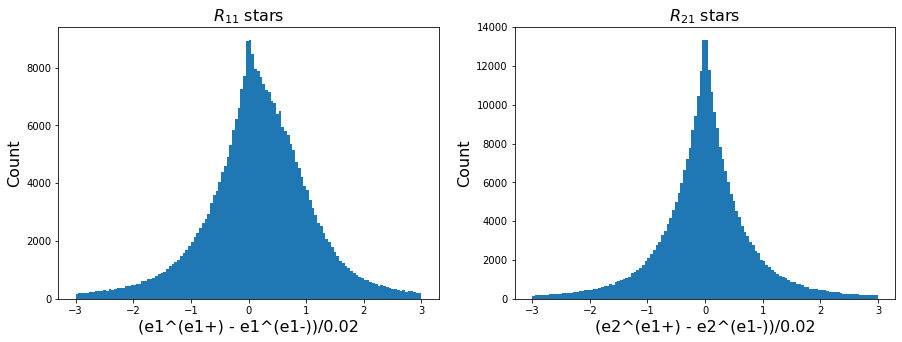

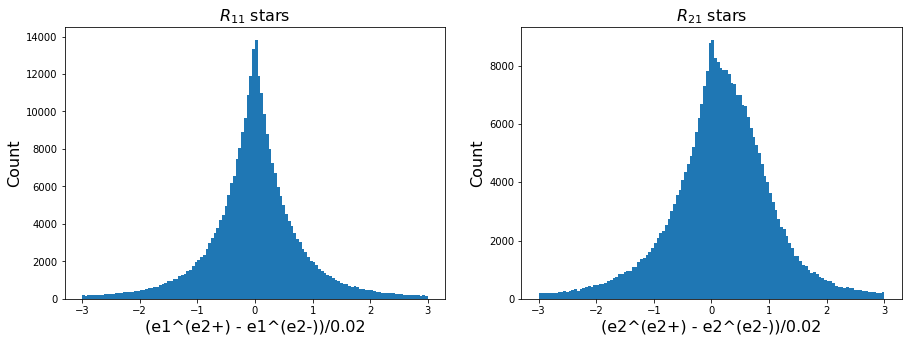

In [26]:
R11_stars = (dd['NGMIX_ELL_1P'][mask_stars][:,0] - dd['NGMIX_ELL_1M'][mask_stars][:,0]) / (2 * dg)
R12_stars = (dd['NGMIX_ELL_1P'][mask_stars][:,1] - dd['NGMIX_ELL_1M'][mask_stars][:,1]) / (2 * dg)

R22_stars = (dd['NGMIX_ELL_2P'][mask_stars][:,1] - dd['NGMIX_ELL_2M'][mask_stars][:,1]) / (2 * dg)
R21_stars = (dd['NGMIX_ELL_2P'][mask_stars][:,0] - dd['NGMIX_ELL_2M'][mask_stars][:,0]) / (2 * dg)

fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R11_stars, bins=126, range=range)
_ = xlabel(f'(e1^(e1+) - e1^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$ stars', size=size)

subplot(122)
_ = hist(R12_stars, bins=126, range=range)
_ = xlabel(f'(e2^(e1+) - e2^(e1-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$ stars', size=size)


fig = figure(figsize=(15, 5))
subplot(121)
_ = hist(R21_stars, bins=126, range=range)
_ = xlabel(f'(e1^(e2+) - e1^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{11}$ stars', size=size)

subplot(122)
_ = hist(R22_stars, bins=126, range=range)
_ = xlabel(f'(e2^(e2+) - e2^(e2-))/{2*dg}', size=size)
_ = ylabel('Count', size=size)
_ = plt.title('$R_{21}$ stars', size=size)


print('Mean(R11_stars) = ', np.mean(R11_stars))
print('Mean(R12_stars) = ', np.mean(R12_stars))
print('Mean(R21_stars) = ', np.mean(R21_stars))
print('Mean(R22_stars) = ', np.mean(R22_stars))

## 4th session
28/10/2021

Compute $\rho$ statistics to quantify errors in PSF model

Install `treecorr` and `Stile`
```
pip install treecorr
pip install git+https://github.com/tobias-liaudat/Stile
```

In [27]:
import treecorr
import stile
print("treecorr:" ,treecorr.__version__)
print("Stile: @tobias-liaudat's fork")

treecorr: 4.2.6
Stile: @tobias-liaudat's fork


In [28]:
# Create Rho1 test object
rho1_test = stile.CorrelationFunctionSysTest('Rho1')

In [29]:
# Show quantities that need to be assigned for rho1 correlation computation
rho1_test.required_quantities

[('ra', 'dec', 'g1', 'g2', 'psf_g1', 'psf_g2', 'w')]

In [30]:
# We do not have floating point weights for stars. Here
# we just use binary weights to remove flagged and masked objects.

star_flags = stars_cat['FLAG_STAR_HSM']
psf_flags = stars_cat['FLAG_PSF_HSM']
w = np.abs(star_flags - 1) * np.abs(psf_flags - 1)

In [31]:
import astropy.units as u

In [32]:
# Create Table with required quantities
stilecat = Table({'ra':stars_cat['RA'], 'dec':stars_cat['DEC'],
                 'g1':stars_cat['E1_STAR_HSM'], 'g2':stars_cat['E2_STAR_HSM'],
                 'psf_g1':stars_cat['E1_PSF_HSM'], 'psf_g2':stars_cat['E2_PSF_HSM'],
                 'w':w})

In [33]:
# Create TreeCorr configuration

sep_units = 'arcmin'
TreeCorrConfig = {
        'ra_units': 'degrees',
        'dec_units': 'degrees',
        'max_sep': '3e2',
        'min_sep': 5e-1,
        'sep_units': sep_units,
        'nbins': 32
    }

In [34]:
# Compute rho statistics rho_1
results = rho1_test(stilecat, config=TreeCorrConfig)

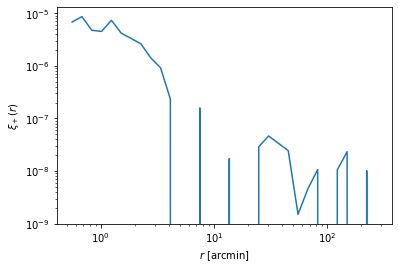

In [35]:
_ = loglog(results['meanr'], results['xip'])
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\xi_+(r)$')

In [36]:
# Compute with different output separation units
sep_units = 'degrees'
TreeCorrConfig = {
        'ra_units': 'degrees',
        'dec_units': 'degrees',
        'max_sep': '1',
        'min_sep': 5e-2,
        'sep_units': sep_units,
        'nbins': 20

}

In [37]:
results = rho1_test(stilecat, config=TreeCorrConfig)

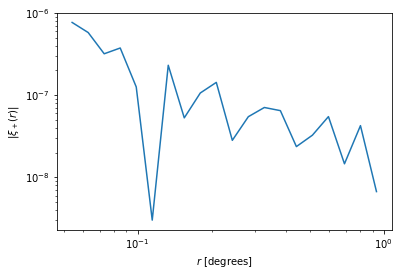

In [38]:
_ = loglog(results['meanr'], abs(results['xip']))
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$|\xi_+(r)|$')

## 5th session
04/11/2021

Compute object-wise leakage between PSF and galaxy ellipticities, using some rough estimates.

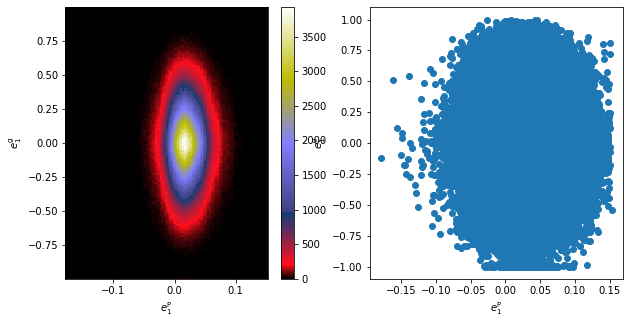

In [39]:
# Plot PSF versus galaxy elliptities.
# Use PSF interpolated to galaxy positions, thus extract PSF
# ellipticity from galaxy catalogue

gal_e = dd['NGMIX_ELL_NOSHEAR'][mask_spread_mod]
psf_e = dd['NGMIX_ELL_PSFo_NOSHEAR'][mask_spread_mod]

figure(figsize=(10,5))

subplot(121)
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
colorbar()
xlabel(r'$e_1^{{\rm P}}$')
ylabel(r'$e_1^{{\rm g}}$')


subplot(122)
scatter(psf_e[:,0], gal_e[:,0])
xlabel(r'$e_1^{{\rm P}}$')
_ = ylabel(r'$e_1^{{\rm g}}$')

In [40]:
# By eye, it does not look as if there is a correlation in the plot.
# Let us fit a straight line to quantify this.

from scipy.optimize import curve_fit

def lin(x, a, b):
    return a*x + b

results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,0])

In [41]:
a_best, b_best = results
print(f'Best-fit slope     a = {a_best:.3g}')
print(f'Best-fit intercept b = {b_best:.3g}')

Best-fit slope     a = -0.0108
Best-fit intercept b = -3.77e-05


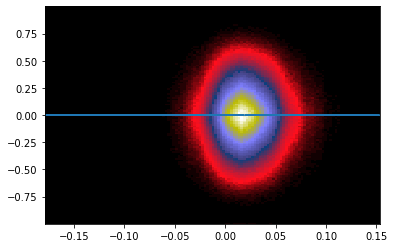

In [42]:
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))

In [43]:
# The intercept should in principle be close to the mean galaxy ellipcitiy.
# Check:
print('mean e1', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,0][mask_spread_mod]))
print('mean e2', np.mean(dd['NGMIX_ELL_NOSHEAR'][:,1][mask_spread_mod]))

mean e1 -0.000256217876561979
mean e2 0.00037109044814758965


In [44]:
# Not far off!

# The slope is 1%, which means that the leakage is small.

In [45]:
np.sqrt(np.diag(cov))

array([0.00670006, 0.00020267])

Leakage e_1^P -> e_1^g
[-1.07761637e-02 -3.76958289e-05]
Leakage e_1^P -> e_2^g
[-0.00075798  0.00038646]
Leakage e_2^P -> e_1^g
[ 0.01166949 -0.00032102]
Leakage e_1^P -> e_2^g
[-0.00948852  0.00042378]


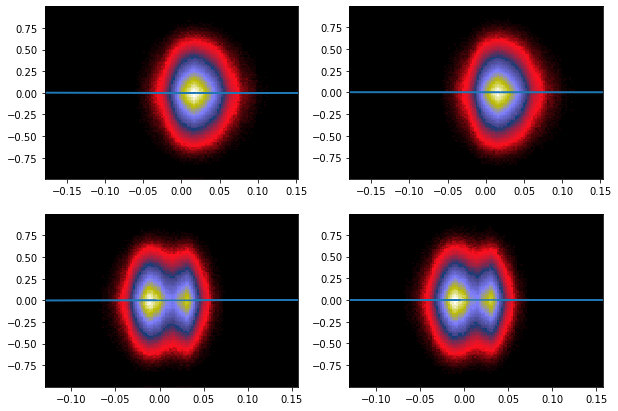

In [46]:
# Fit and plot all combinations of components

figure(figsize=[10,7])

subplot(221)
hist2d(psf_e[:,0], gal_e[:,0], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,0])
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))
print(r'Leakage e_1^P -> e_1^g')
print(results)

subplot(222)
hist2d(psf_e[:,0], gal_e[:,1], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,0], gal_e[:,1])
plot(psf_e[:,0], lin(psf_e[:,0], results[0], results[1]))
print(r'Leakage e_1^P -> e_2^g')
print(results)

subplot(223)
hist2d(psf_e[:,1], gal_e[:,0], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,1], gal_e[:,0])
plot(psf_e[:,1], lin(psf_e[:,1], results[0], results[1]))
print(r'Leakage e_2^P -> e_1^g')
print(results)

subplot(224)
hist2d(psf_e[:,1], gal_e[:,1], bins=128, cmap='gist_stern');
results, cov = curve_fit(lin, psf_e[:,1], gal_e[:,1])
plot(psf_e[:,1], lin(psf_e[:,1], results[0], results[1]))
print(r'Leakage e_1^P -> e_2^g')
print(results)

In [47]:
# The cross-component leakage is very small, which is great.

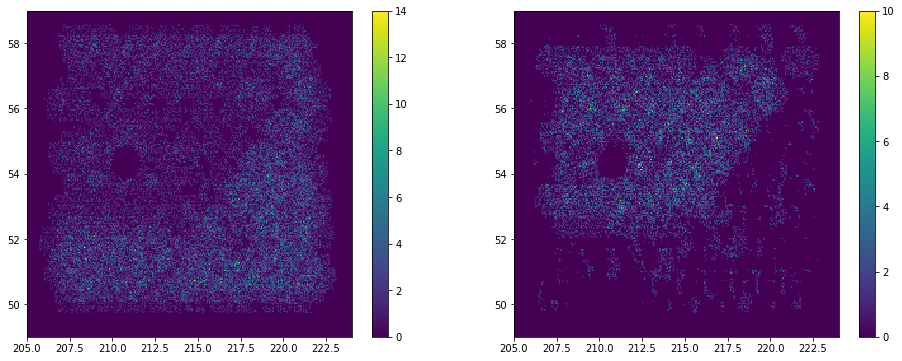

In [48]:
# Examine the strange bi-modality in e_2^P.
# See whether there is a spatial dependency.

figure(figsize=(16,6))
subplot(121)
mask_e2 = stars_cat['E2_PSF_HSM'] > 0.
hist2d(stars_cat['RA'][mask_e2], stars_cat['DEC'][mask_e2], range=[[205, 224], [49, 59]], bins=256);
colorbar()

subplot(122)
mask_e2 = stars_cat['E2_PSF_HSM'] < 0.
hist2d(stars_cat['RA'][mask_e2], stars_cat['DEC'][mask_e2], range=[[205, 224], [49, 59]], bins=256);
_ = colorbar()

In [49]:
# Yes! Positive and negative PSF ellipticty (component 2) are clearly separated spatially.
# This might come from the observing conditions and stratgey.

# 6th session

25/11/2021

Compute scale-dependent leakage function $\alpha(\theta)$.
This function is defined as follows.

$$
    \alpha(\theta) = \frac{\xi_{+}^{\rm gP}(\theta) - \langle e^{\rm g} \rangle^{*} \langle e^{\rm P} \rangle}{\xi_{+}^{\rm PP}(\theta) - |\langle e^{\rm P} \rangle|^{2}}
$$

With g = galaxy and P = PSF.

In [50]:
# So, first let up compute the galaxy - PSF cross-correlation function xi_+^{gP}.
# Use TreeCorr

# Create TreeCorr configuration
sep_units = 'arcmin'
TreeCorrConfig = {
        'ra_units': 'degrees',
        'dec_units': 'degrees',
        'max_sep': '3e2',
        'min_sep': 5e-1,
        'sep_units': sep_units,
        'nbins': 32
    }

In [51]:
# Create TreeCorr catalogue #1: galaxies

ra_gal = dd['XWIN_WORLD'][mask_spread_mod]
dec_gal = dd['YWIN_WORLD'][mask_spread_mod]
w_gal = np.ones(ra_gal.shape)

cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, g1=gal_e[:,0], g2=gal_e[:,1],
                            w=w_gal, ra_units='degrees', dec_units='degrees')

In [52]:
# Create TreeCorr catalogue #2: PSF
# Since this is no longer an object-wide compuation, we do not have to use the PSF interpolated at the galaxy
# positions, but can use the PSF from the star/PSF validation catalogue.

# TODO: Remove duplicates from multiple exposures at same position.

ra_psf = stars_cat['RA']
dec_psf = stars_cat['DEC']
psf_g1 = stars_cat['E1_PSF_HSM']
psf_g2 = stars_cat['E2_PSF_HSM']
w_psf = w

cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, g1=psf_g1, g2=psf_g2,
                            w=w_psf, ra_units='degrees', dec_units='degrees')

In [53]:
# Create and process correlation object

ng = treecorr.GGCorrelation(TreeCorrConfig)

ng.process(cat_gal, cat_psf)

In [54]:
ng

GGCorrelation(config={'max_sep': 300.0, 'min_sep': 0.5, 'sep_units': 'arcmin', 'nbins': 32, 'brute': False, 'verbose': 1, 'split_method': 'mean', 'max_top': 10, 'precision': 4, 'pairwise': False, 'm2_uform': 'Crittenden', 'metric': 'Euclidean', 'bin_type': 'Log', 'var_method': 'shot', 'num_bootstrap': 500})

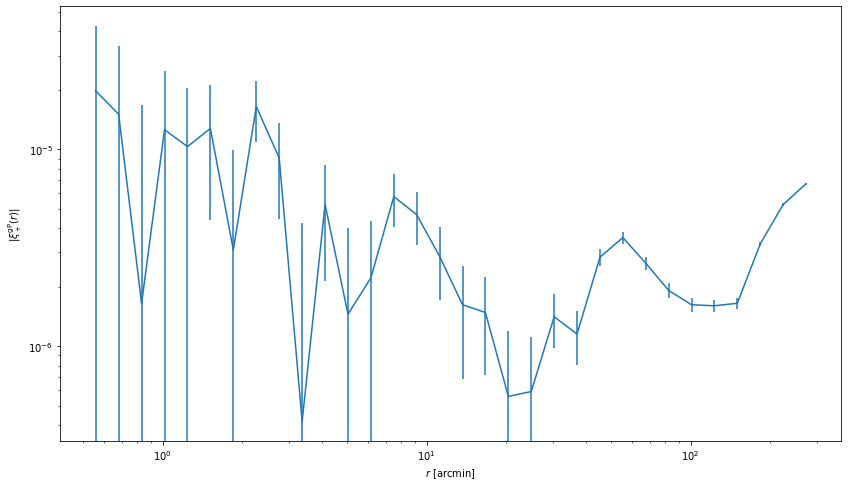

In [55]:
# Create plot with error bars. Error bars are computed by treecorr, and are here shape/shot noise only.
figure(figsize=(14,8))
_ = errorbar(ng.meanr, abs(ng.xip), yerr=np.sqrt(ng.varxip))
loglog()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$|\xi^{{\rm gP}}_+(r)|$')

# 7th session

2/12/2021

Continue with the scale-dependent leakage function $\alpha(\theta)$.

In [56]:
# Compute the PSF - PSF autocorrelation function.
# The PSF catalogue has already been done last time, so we just have to create a new correlation object
# and process it.

pp = treecorr.GGCorrelation(TreeCorrConfig)
pp.process(cat_psf, cat_psf)

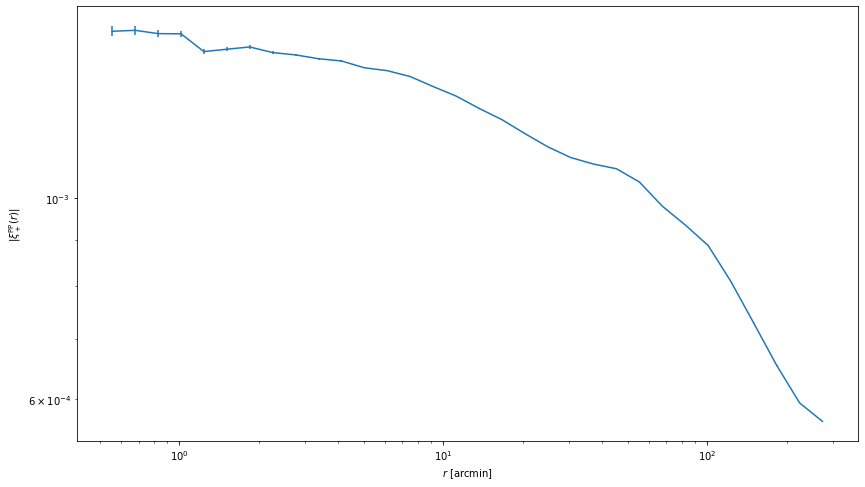

In [57]:
figure(figsize=(14,8))
_ = errorbar(pp.meanr, pp.xip, yerr=np.sqrt(pp.varxip))
_ = plt.loglog()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$|\xi^{{\rm PP}}_+(r)|$')

In [58]:
# Now compute the average ellipticit values.

# PSF ellipticity, as compex number
psf_g_bar = np.mean(psf_g1 + psf_g2 * 1j)

# Multiply with the galaxy ellipticity (complex conjugated), and take real values (not explicitely
# written in equation)
eg_psf_g_bar = np.real(np.mean((gal_e[:,0] - gal_e[:,1]*1j)) * psf_g_bar)

# Also compute the rms as check
psf_g_rms = np.std(psf_g1 + psf_g2 * 1j)

# RMS is larger than mean, even absolute mean...not sure that this makes much sense, but
# at the moment we ignore this.
print(np.abs(psf_g_bar), psf_g_rms)
print(len(psf_g1))

0.025787581251757917 0.049055675462149784
87687


In [59]:
# Now we have everything together to compute alpha(theta)

alpha = (ng.xip - eg_psf_g_bar) / (pp.xip - np.abs(psf_g_bar)**2)

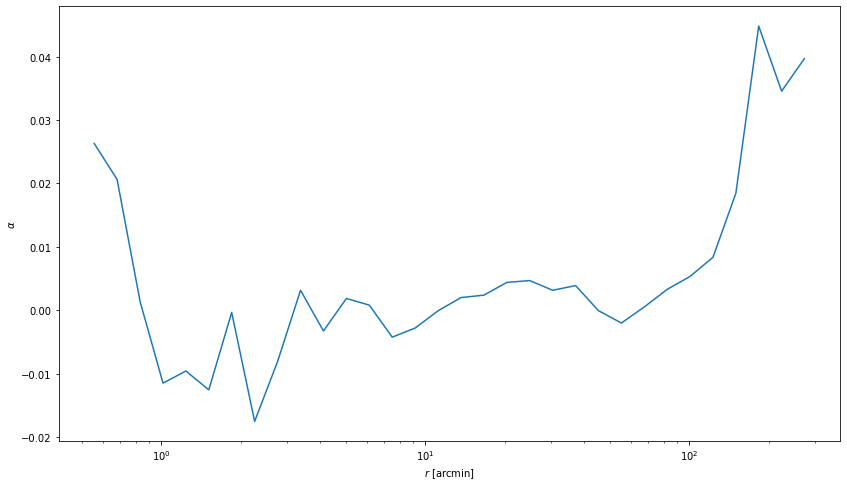

In [60]:
# Plot, without error bars (for that we would need to propagate the errors of all components)

figure(figsize=(14,8))
_ = plot(pp.meanr, alpha)
_ = plt.semilogx()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\alpha$')

### Now let's look at Planck clusters!

In [67]:
# There are four SZ clusters in the W3 footprint. Here are the coordinates, from the catalogue
# available at the Planck webpage.

clusters = [(218.83875087412983, 55.14134974316738),
 (216.77906936376968, 55.74970443037433),
 (217.1485398057025, 56.876583531173544),
 (213.6782168416283, 54.783574398561655)]

In [68]:
# Create a catalogue with the cluster positions. No shapes required, since we will correlate CFIS shapes
# with cluster positions.

ra_cl = np.array(clusters)[:,0]
dec_cl = np.array(clusters)[:,1]
w_cl = np.ones_like(ra_cl)

cat_cl = treecorr.Catalog(ra=ra_cl, dec=dec_cl, w=w_cl, ra_units='degrees', dec_units='degrees')

In [69]:
xp = treecorr.NGCorrelation(TreeCorrConfig)
xp.process(cat_cl, cat_gal)


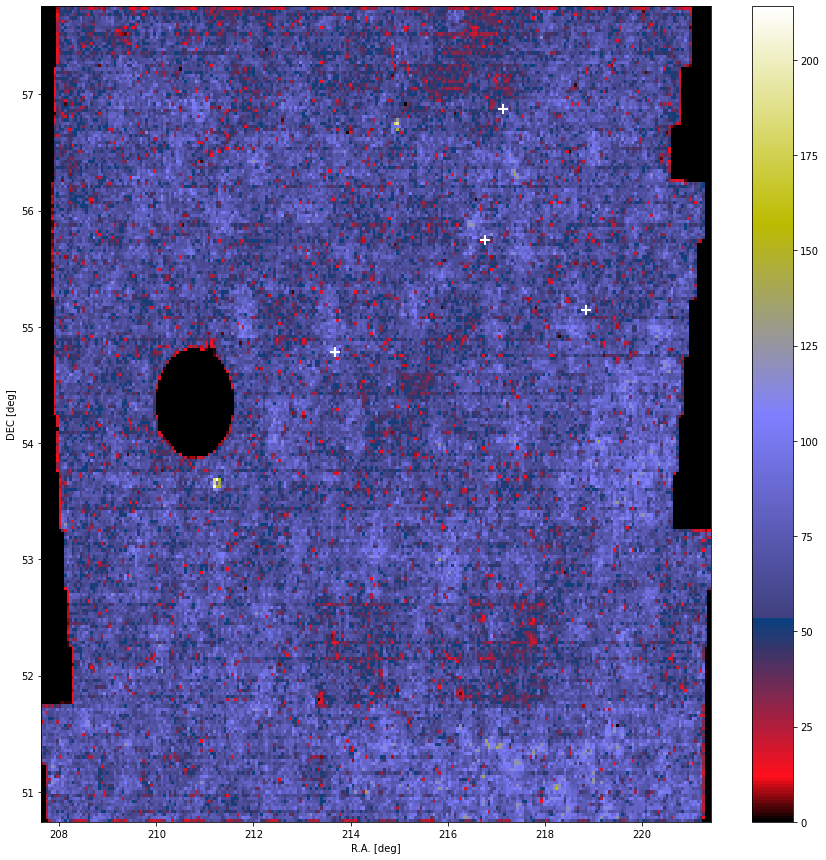

In [70]:
# Plot the cluster positions in the W3 footprint, to make sure they are not in a mask or at the border

figure(figsize=(15, 15))
hist2d(dd['XWIN_WORLD'][mask], dd['YWIN_WORLD'][mask], 256, cmap='gist_stern');
xlabel('R.A. [deg]')
ylabel('DEC [deg]')
plot(ra_cl, dec_cl, 'w+', markersize=10, markeredgewidth=2)
_ = colorbar()

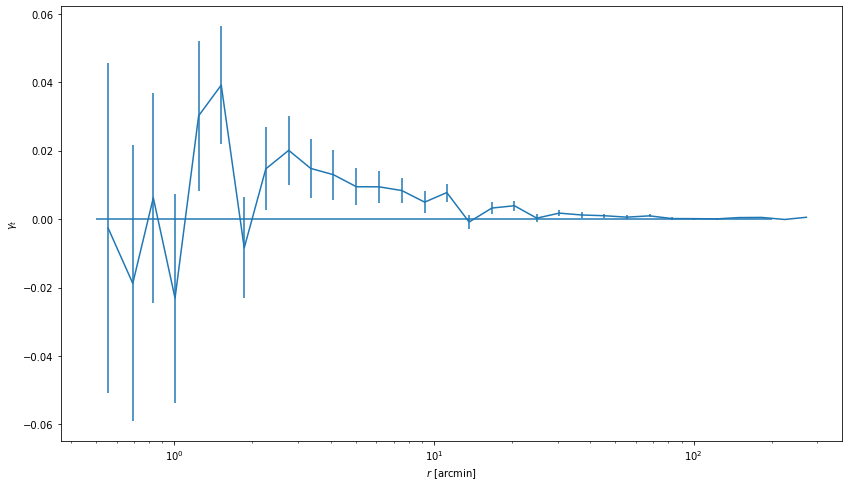

In [71]:
# And voila the plot, with errorbars
# It looks like there is a positive signal!
# This is the mean tangential shear as function of distance to the cluster center.
# In principle (modulo systematics and our many approximations here) this
# is the real weak-lensing distortion signal of CFIS galaxies due of the massive SZ clusters.

figure(figsize=(14,8))
_ = errorbar(xp.meanr, xp.xi, yerr=np.sqrt(xp.varxi))
plt.hlines(y=0, xmin=0.5, xmax=200)
plt.semilogx()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\gamma_t$')

# 8th session

09/12/2021


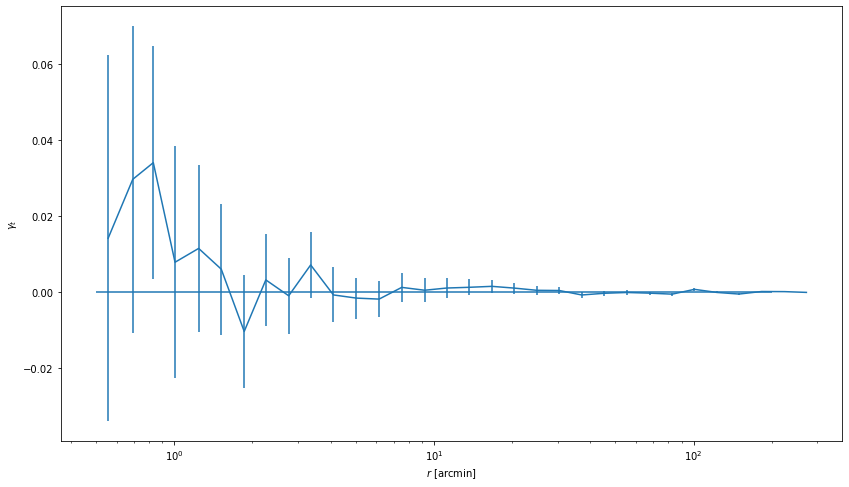

In [75]:
# Plotting the B-mode of the previous plot. It should be consistent with zero.

figure(figsize=(14,8))
_ = errorbar(xp.meanr, xp.xi_im, yerr=np.sqrt(xp.varxi))
plt.hlines(y=0, xmin=0.5, xmax=200)
plt.semilogx()
_ = plt.xlabel(f'$r$ [{sep_units}]')
_ = plt.ylabel(r'$\gamma_t$')


In [85]:
# Galaxy density (number of gal / arcmin^2)
ngal = 6
# Galaxy shape noise (~ 0.3 < sigma_ep < 0.4)
sigma_ep = np.sqrt(np.mean(gal_e[:,0]**2 + gal_e[:,1]**2))

# Area in arcmin^2
area = np.pi * 100**2 
# Number of background densitites
nb_bk_gal = area * ngal

# Noise 
noise_calc = sigma_ep / np.sqrt(nb_bk_gal * 3e3) *(1/np.sqrt(2))
noise_calc


1.0725777321253956e-05

In [121]:
# S/N estimation
signal = 6.7e-5

SN = signal / noise_calc
SN


6.246633506667561

In [95]:
# Load SDSS catalog and randoms
sdss_cat = np.loadtxt('./sdss/sdssgroup_cfis.dat')
random_cfis_cat = np.loadtxt('./sdss/random_cfis.dat')
axel_random = np.load('./sdss/w3_randoms.npy')


/Users/tliaudat/opt/anaconda3/envs/WF_PSF/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


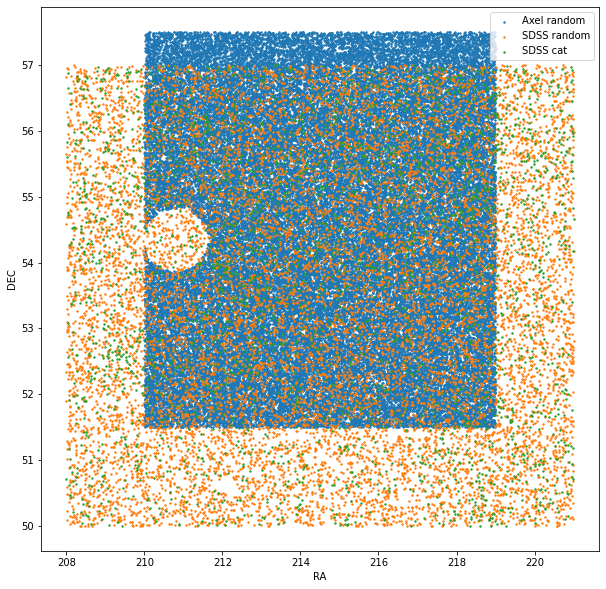

In [118]:
plt.figure(figsize=(10,10))
plt.scatter(axel_random['ra'], axel_random['dec'], s=2, label='Axel random')
plt.scatter(random_cfis_cat[:,0], random_cfis_cat[:,1], s=2, label='SDSS random')
plt.scatter(sdss_cat[:,0], sdss_cat[:,1], s=2, label='SDSS cat')
plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()


In [120]:
# Max and min RA,DEC on the SDSS footprint
ra_min = np.min(sdss_cat[:,0])
ra_max = np.max(sdss_cat[:,0])

dec_min = np.min(sdss_cat[:,1])
dec_max = np.max(sdss_cat[:,1])

print('RA: \t', ra_min, ra_max)
print('DEC: \t', dec_min, dec_max)


RA: 	 208.00329746 220.999885828
DEC: 	 50.000595057 56.997399792
